# IMDB sentiment analysis

Let us start by including all the modules we will need

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re

# String preprocessing functions

Here are the functions that we will use to preprocess the movie review strings and tokenize them.
Some of the modifications we make during the preprocessing will be motivated by the format of the reviews in the dataset.

In [2]:
def preprocess_string(string):
    # Remove HTML tags
    string = re.sub("<[^>]*>", " ", string)
    # Remove all non-alphanumerical characters and replace them with whitespace
    string = re.sub("[^A-Za-z0-9 ]+", " ", string)
    # Replace multiple contiguous whitespaces by a single one
    string = re.sub("\s+", " ", string)

    # Trim the string to remove trailing whitespaces if there are any
    string = string.strip()

    # Convert string to lowercase
    string = string.lower()

    return string

def tokenize(string):
    # To tokenize a string, we first preprocess it and then convert each word into a token
    string = preprocess_string(string)
    return string.split(" ")

def get_token_index(token, vocabulary, add_if_unknown=False):
    if vocabulary.get(token) is None:
        if add_if_unknown:
            vocabulary[token] = len(vocabulary)
        else:
            return vocabulary["[UNKNOWN]"]

    return vocabulary[token]

def get_token_indices(list_of_tokens, vocabulary, add_if_unknown=False):
    return [get_token_index(token, vocabulary, add_if_unknown=add_if_unknown) for token in list_of_tokens]

# Loading the dataset and data exploration

Next, let us load the dataset from the CSV file using `pandas`

In [3]:
full_dataset = pd.read_csv("imdb.csv")

Let us get a quick sneak-peak of the format of the data and how many samples it consists of

In [4]:
full_dataset

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


We can see that the dataset consists of 50000 samples, each of which contains the text of the review and the corresponding sentiment.
Before proceeding with any data exploration, let us split our dataset into train, validation and test datasets.

In [5]:
train_valid_dataset, test_dataset = train_test_split(full_dataset, test_size=0.1)
train_dataset, valid_dataset = train_test_split(train_valid_dataset, test_size=1/9)

Let us see what the exact numbers are for the distributions of train/validation/test datasets and positive/negative reviews in the training dataset is.

In [6]:
print("The training dataset consists of {} samples".format(len(train_dataset)))
print("The validation dataset consists of {} samples".format(len(valid_dataset)))
print("The test dataset consists of {} samples".format(len(test_dataset)))

positive_num = len(train_dataset[train_dataset['sentiment'] == 'positive'])
negative_num = len(train_dataset) - positive_num
print("In the dataset there are {} positive reviews and {} negative reviews".format(positive_num, negative_num))

The training dataset consists of 40000 samples
The validation dataset consists of 5000 samples
The test dataset consists of 5000 samples
In the dataset there are 20030 positive reviews and 19970 negative reviews


We see it is very balanced! Great!

In order to get a feel for the format of the reviews, let us write out a few examples.

In [7]:
for i in range(3):
    print("Example #{} ({}): {}\n".format(i+1, train_dataset.iloc[i]["sentiment"], train_dataset.iloc[i]["review"]))

Example #1 (positive): If you ever see a stand up comedy movie this is the one. You will laugh nonstop if you have any sense of humor at all. This is a once in a lifetime performance from a once in a lifetime performer. This is a stand up standard.

Example #2 (positive): I saw this movie when I was in Israel for the summer. my Hebrew is not fluent, so the subtitles were very useful, I didn't feel lost at any point in the movie. You tend to get used to subtitles after about 5 minutes.<br /><br />This movie blew me away!!!!!! It depicts two of the most prominent taboos in the middle east today: A homosexual relationship between an Israeli and a Palestinian. It allows a person to enter both realms of the conflict simultaneously. The dilemma, the emotions entailed. The movie climaxes in tragedy when anger and rage drive one of the lovers to one extremist side! an absolute must see!!

Example #3 (positive): BONJOUR, MONSIEUR SHLOMI is simply a wonderful film! Writer/Director Shemi Zarhin h

We based our string preprocessing function on these examples. For example, we can see that there are some HTML tags in the revies, so we remove them during preprocessing. Let's check an example:

In [8]:
preprocess_string(train_dataset.iloc[0]["review"])

'if you ever see a stand up comedy movie this is the one you will laugh nonstop if you have any sense of humor at all this is a once in a lifetime performance from a once in a lifetime performer this is a stand up standard'

Now, let's apply the preprocessing and tokenization, as well as initialize our vocabulary.

In [9]:
def preprocess_dataset(dataset, vocabulary, add_tokens_to_vocabulary_proportion=0):
    # We include a parameter to control for what proportion of the samples e should add unknown tokens to the vocabulary
    if add_tokens_to_vocabulary_proportion == 0:
        dataset["token_ids"] = dataset["review"].apply(lambda x: get_token_indices(tokenize(preprocess_string(x)), vocabulary, add_if_unknown=False))
    else:
        first_dataset, second_dataset = train_test_split(dataset, test_size=1-add_tokens_to_vocabulary_proportion)
        first_dataset["token_ids"] = first_dataset["review"].apply(lambda x: get_token_indices(tokenize(preprocess_string(x)), vocabulary, add_if_unknown=True))
        second_dataset["token_ids"] = second_dataset["review"].apply(lambda x: get_token_indices(tokenize(preprocess_string(x)), vocabulary, add_if_unknown=False))
        dataset = pd.concat([first_dataset, second_dataset])
        
    dataset["sentiment"] = dataset["sentiment"].apply(lambda x: 1 if x == "positive" else 0)
    dataset = dataset.drop("review", axis=1)
    return dataset

In [10]:
vocabulary = {"[UNKNOWN]": 0, "[PAD]": 1}

# We will add tokens to the vocabulary for the first 90% of the training set. This way, we will train with some unknown tokens.
train_dataset = preprocess_dataset(train_dataset, vocabulary, add_tokens_to_vocabulary_proportion=0.90) 
valid_dataset = preprocess_dataset(valid_dataset, vocabulary)
test_dataset = preprocess_dataset(test_dataset, vocabulary)

print("The vocabulary consists of {} words".format(len(vocabulary)))

The vocabulary consists of 88668 words


Finally, we will load the data into a format that `pytorch` can work with and organize it into batches.

In [11]:
def dataframe_to_python(dataframe):
    sequences = list(dataframe["token_ids"])
    sentiments = list(dataframe["sentiment"])
    return list(zip(sequences, sentiments))

In [12]:
BATCH_SIZE = 64

def collate(batch):
    tokens = [x[0] for x in batch]
    tokens = nn.utils.rnn.pad_sequence([torch.tensor(token, dtype=torch.int64) for token in tokens], padding_value=vocabulary["[PAD]"], batch_first=True)
    lengths = [len(x[0]) for x in batch]
    lengths = torch.tensor(lengths, dtype=torch.int64)
    labels = [[x[1]] for x in batch]
    labels = torch.tensor(labels, dtype=torch.float)
    return (tokens, lengths, labels)

train_dataloader = torch.utils.data.DataLoader(dataframe_to_python(train_dataset), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate)
valid_dataloader = torch.utils.data.DataLoader(dataframe_to_python(valid_dataset), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(dataframe_to_python(test_dataset), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate)

print("The training dataset consists of {} batches".format(len(train_dataloader)))

The training dataset consists of 625 batches


# Building the model

The model I have chosen to use consists of the following layers:
- A word embedding layer (with the embedding space having dimension 16)
- 3 layers of LSTMs (with 16 hidden units), followed by dropout (with rate 0.2)
- A densely connected layer

First, let us set some of the hyperparameters of our model.

In [13]:
LSTM_LAYERS = 3
EMBEDDING_DIM = 20
HIDDEN_DIM = 32
BIDIRECTIONAL = False
DROPOUT_RATE = 0.25

MAX_EPOCHS = 25
LEARNING_RATE = 0.0005
EARLY_STOPPING = 3

Next, we define the model.

In [14]:
class Model(nn.Module):
    def __init__(self, vocabulary_size, embedding_dimension, hidden_state_dimension, lstm_layers, bidirectional, dropout_rate):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_dimension)
        self.lstm = nn.LSTM(embedding_dimension, hidden_state_dimension, lstm_layers, bidirectional=bidirectional,
                            dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.dense = nn.Linear(hidden_state_dimension*2 if bidirectional else hidden_state_dimension, 1)
        
    def forward(self, sequence, length):
        embedded_sequence = torch.nn.utils.rnn.pack_padded_sequence(self.embedding(sequence), length, batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.lstm(embedded_sequence)
        lstm_result = torch.cat([hidden[-1], hidden[-2]], dim=-1) if self.lstm.bidirectional else hidden[-1]
        lstm_result = self.dropout(lstm_result)
        result = self.dense(lstm_result)
        return torch.sigmoid(result)

In [15]:
# We will use the GPU if it is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model
model = Model(len(vocabulary), EMBEDDING_DIM, HIDDEN_DIM, LSTM_LAYERS, BIDIRECTIONAL, DROPOUT_RATE)
model.to(device)

# Define the loss function and optimizer (and a function to compute accuracy)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

def accuracy_fn(predicted, label):
    correct = (np.abs(predicted - label) < 0.5)
    return correct.sum() / predicted.shape[0]

We can now start the training. We will use early stopping in the validation set to determine when to stop the training.

In [16]:
best_model = None
best_accuracy = 0.0
epochs_without_improvements = 0

history = {
    "train_loss": [],
    "train_accuracy": [],
    "valid_loss": [],
    "valid_accuracy": [],
}

for epoch in range(MAX_EPOCHS):

    # Train the model

    model.train()

    train_loss = 0.0
    train_accuracy = 0.0
    for i, data in enumerate(train_dataloader):
        # Prepare the data
        sequence, length, label = data
        sequence = sequence.to(device)
        label = label.to(device)

        # Reset the gradients
        optimizer.zero_grad()
        
        # Compute the predictions, the loss and the accuracy
        prediction = model(sequence, length)
        loss = loss_fn(prediction, label)

        train_loss += loss.detach().cpu().numpy()
        train_accuracy +=  accuracy_fn(prediction.detach().cpu().numpy(), label.cpu().numpy())

        # Update the weights
        loss.backward()
        optimizer.step()

        # Print the updated loss/accuracy
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {train_loss / (i+1):.3f} accuracy: {train_accuracy / (i+1):.3f}', end='\r')

    # Evaluate on the validation set
    
    model.eval()

    valid_loss = 0.0
    valid_accuracy = 0.0
    for j, data in enumerate(valid_dataloader):
        # Prepare the data
        sequence, length, label = data
        sequence = sequence.to(device)
        label = label.to(device)
        
        # Compute the predictions and the loss
        prediction = model(sequence, length)
        loss = loss_fn(prediction, label)
        
        valid_loss += loss.detach().cpu().numpy()
        valid_accuracy +=  accuracy_fn(prediction.detach().cpu().numpy(), label.cpu().numpy())

        # Print the updated loss/accuracy
        print(f'[{epoch + 1}, {i + 1:5d}]  loss: {train_loss / (i+1):.3f} accuracy: {train_accuracy / (i+1):.3f}  valid_loss: {valid_loss / (j+1):.3f} valid_accuracy: {valid_accuracy / (j+1):.3f}', end='\r')

    print(f'[{epoch + 1}, {i + 1:5d}]  loss: {train_loss / (i+1):.3f} accuracy: {train_accuracy / (i+1):.3f}  valid_loss: {valid_loss / (j+1):.3f} valid_accuracy: {valid_accuracy / (j+1):.3f}')

    # Store the losses/accuracies

    train_loss /= i + 1
    train_accuracy /= i + 1
    valid_loss /= j + 1
    valid_accuracy /= j + 1

    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    history["valid_loss"].append(valid_loss)
    history["valid_accuracy"].append(valid_accuracy)

    # Check whether we should stop because of early stopping

    if valid_accuracy > best_accuracy:
        best_model = model.state_dict()
        best_accuracy = valid_accuracy
        epochs_without_improvements = 0
    else:
        epochs_without_improvements += 1
        if epochs_without_improvements >= EARLY_STOPPING:
            model.load_state_dict(best_model)
            print("Stopping due to early stopping")
            break
    
    

[1,   625]  loss: 0.660 accuracy: 0.593  valid_loss: 0.597 valid_accuracy: 0.682
[2,   625]  loss: 0.569 accuracy: 0.708  valid_loss: 0.532 valid_accuracy: 0.732
[3,   625]  loss: 0.519 accuracy: 0.749  valid_loss: 0.514 valid_accuracy: 0.743
[4,   625]  loss: 0.481 accuracy: 0.780  valid_loss: 0.454 valid_accuracy: 0.789
[5,   625]  loss: 0.431 accuracy: 0.810  valid_loss: 0.501 valid_accuracy: 0.773
[6,   625]  loss: 0.394 accuracy: 0.829  valid_loss: 0.402 valid_accuracy: 0.818
[7,   625]  loss: 0.362 accuracy: 0.849  valid_loss: 0.370 valid_accuracy: 0.839
[8,   625]  loss: 0.335 accuracy: 0.862  valid_loss: 0.693 valid_accuracy: 0.791
[9,   625]  loss: 0.318 accuracy: 0.873  valid_loss: 0.363 valid_accuracy: 0.854
[10,   625]  loss: 0.296 accuracy: 0.883  valid_loss: 0.340 valid_accuracy: 0.855
[11,   625]  loss: 0.283 accuracy: 0.888  valid_loss: 0.331 valid_accuracy: 0.860
[12,   625]  loss: 0.266 accuracy: 0.899  valid_loss: 0.319 valid_accuracy: 0.865
[13,   625]  loss: 0.255 

# Results

First, let us plot a graph of how the loss and accuracy have evolved over time.

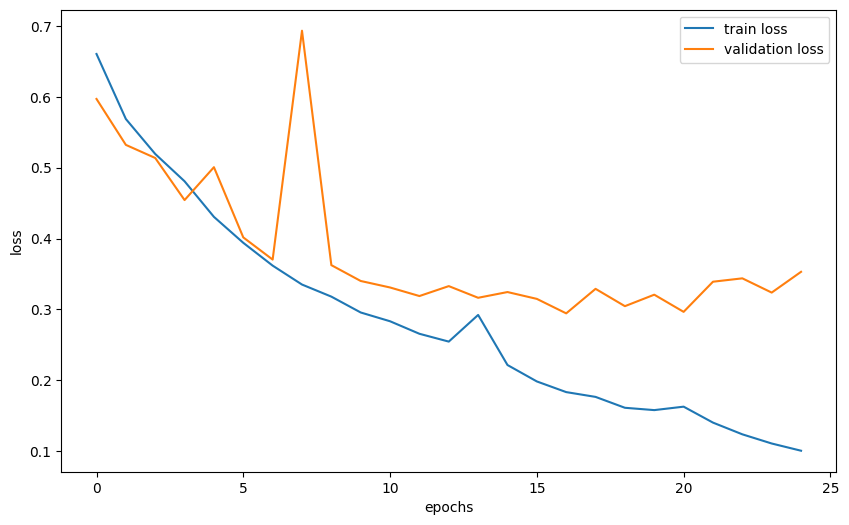

In [17]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(history["train_loss"], label='train loss')
ax.plot(history["valid_loss"], label='validation loss')
plt.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss');

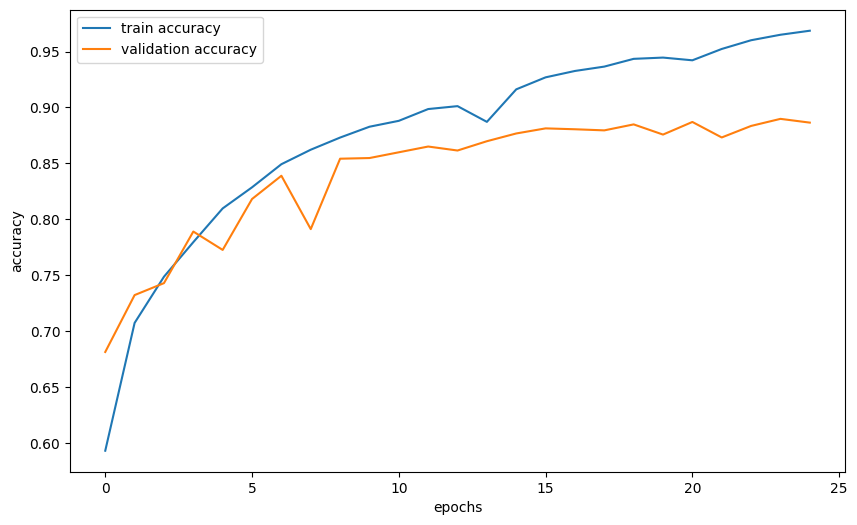

In [18]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(history["train_accuracy"], label='train accuracy')
ax.plot(history["valid_accuracy"], label='validation accuracy')
plt.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy');

Finally, let's evaluate our performance on the test set.

In [19]:
model.eval()

test_accuracy = 0.0
for j, data in enumerate(test_dataloader):
    # Prepare the data
    sequence, length, label = data
    sequence = sequence.to(device)

    # Compute the prediction and its accuracy
    prediction = model(sequence, length)

    accuracy = accuracy_fn(prediction.detach().cpu().numpy(), label.numpy())
    test_accuracy += accuracy

    # Print the results
    print(f'Final test accuracy: {test_accuracy / (j+1):.3f}', end='\r')

# Print the final result
print(f'Final test accuracy: {test_accuracy / (j+1):.3f}')

Final test accuracy: 0.891


In the end, we got a 89.1% accuracy on the test set. That's not bad considering our model is relatively simple.
It is likely that the true accuracy is lower and we got a bit lucky with the test set, as the accuracy on the validation set is 0.7% lower.

# Further improvements

There are a few things I would have liked to implement and that could improve the model's performance, such as:
- Using automatic hyperparameter tuning and cross-validation.
- Implementing learning rate decay for faster training (and hence faster iterating).
- Analyzing the mistakes that the model makes on the validation set to see what can be improved.
- Increasing regularization, as there was a significant gap between training and validation accuracies.
- Using a pretrained word embedding instead of training one from scratch.